In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from scipy.spatial.distance import cosine, euclidean
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import cv2
from PIL import Image
from evaluation.neuroprobe.config import ROOT_DIR, SAMPLING_RATE
from subject.braintreebank import BrainTreebankSubject
import pandas as pd
import math
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy.stats import pearsonr
from matplotlib.lines import Line2D

SUBJECT_TRIAL_TO_MOVIE = {
    (1,0): 'fantastic-mr-fox.mp4',
    (1,1): 'the-martian.mp4',
    (1,2): 'thor-ragnarok.mp4',
    (2,0): 'venom.mp4',
    (2,1): 'spider-man-3-homecoming.mp4',
    (2,2): 'guardians-of-the-galaxy.mp4',
    (2,3): 'guardians-of-the-galaxy-2.mp4',
    (2,4): 'avengers-infinity-war.mp4',
    (2,5): 'black-panther.mp4',
    (2,6): 'aquaman.mp4',
    (3,0): 'cars-2.mp4',
    (3,1): 'lotr-1.mp4',
    (3,2): 'lotr-2.mp4',
    (4,0): 'shrek-the-third.mp4',
    (4,1): 'megamind.mp4',
    (4,2): 'incredibles.mp4',
    (5,0): 'fantastic-mr-fox.mp4',
    (6,0): 'megamind.mp4',
    (6,1): 'toy-story.mp4',
    (6,2): 'coraline.mp4',
    (7,0): 'cars-2.mp4',
    (7,1): 'megamind.mp4',
    (8,0): 'sesame-street-episode-3990.mp4',
    (9,0): 'ant-man.mp4',
    (10,0): 'cars-2.mp4',
    (10,1): 'spider-man-far-from-home.mp4',
}

CLIP_DIR = "/om2/data/public/braintreebank_movies_clip_preprocessed_2/"
MOVIES_DIR = "/om2/data/public/braintreebank_movies/"

In [2]:
def extract_frame_at_time(video_path, timestamp):
    """
    Extract a frame from video at a specific timestamp.
    
    Args:
        video_path (str): Path to the video file
        timestamp (float): Timestamp in seconds
    Returns:
        PIL.Image: The extracted frame as PIL Image
    """
    cap = cv2.VideoCapture(video_path)
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_number = int(timestamp * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Warning: Could not extract frame at timestamp {timestamp}")
        return None
    
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    
    return pil_image


def obtain_neural_data_index(sub_id, trial_id, movie_times):
    # Data frames column IDs
    start_col, end_col = 'start', 'end'
    trig_time_col, trig_idx_col, est_idx_col, est_end_idx_col = 'movie_time', 'index', 'est_idx', 'est_end_idx'

    # Path to trigger times csv file
    trigger_times_file = os.path.join(ROOT_DIR, f'subject_timings/sub_{sub_id}_trial{trial_id:03}_timings.csv')

    trigs_df = pd.read_csv(trigger_times_file)
    # display(trigs_df.head())

    last_t = trigs_df[trig_time_col].iloc[-1]
    assert np.all(movie_times < last_t), "Movie times must be less than the last trigger time"
    
    # Vectorized nearest trigger finding
    start_indices = np.searchsorted(trigs_df[trig_time_col].values, movie_times)
    start_indices = np.maximum(start_indices, 0) # handle the edge case where movie starts right at the word
    
    # Vectorized sample index calculation
    return np.round(
        trigs_df.loc[start_indices, trig_idx_col].values + 
        (movie_times - trigs_df.loc[start_indices, trig_time_col].values) * SAMPLING_RATE
    ).astype(int)

def get_neural_data_at_index(subject_id, trial_id, electrode, start, end):
    subject = BrainTreebankSubject(subject_id, cache=False)
    neural_data = subject.get_electrode_data(electrode,trial_id,window_from=start, window_to=end)
    return neural_data

In [3]:
def get_movie_data(movie):
    clip_features_path = os.path.join(CLIP_DIR, movie.replace('.mp4', '_clip_features.npy'))
    timestamps_path = os.path.join(CLIP_DIR, movie.replace('.mp4', '_timestamps.npy'))
    movie_path = os.path.join(MOVIES_DIR, movie)

    clip_features = np.load(clip_features_path)  # shape: (num_samples, feature_dim)
    timestamps = np.load(timestamps_path)
    return clip_features, timestamps, movie_path

def get_subject_trial_from_movie(movie):
    subject_trial_list = []
    for subject_trial, movie_name in SUBJECT_TRIAL_TO_MOVIE.items():
        if movie_name == movie:
            subject_trial_list.append(subject_trial)
    return subject_trial_list

def get_unique_electrodes(electrode_locations):
    unique_electrodes = {}
    seen_values = set()
    
    for key, value in electrode_locations.items():
        if value not in seen_values:
            unique_electrodes[key] = value
            seen_values.add(value)
    
    return list(unique_electrodes.keys())

In [4]:
movie = 'ant-man.mp4'
clip_features, timestamps, movie_path = get_movie_data(movie)

subject_trial_list = get_subject_trial_from_movie(movie)
subject_id, trial_id = subject_trial_list[0]
subject = BrainTreebankSubject(subject_id, cache=False)
electrode_locations = {electrode_label: subject.get_electrode_metadata(electrode_label)['DesikanKilliany'] for electrode_label in subject.get_electrode_labels()}
unique_electrodes = electrode_locations.keys()

trigger_times_file = os.path.join(ROOT_DIR, f'subject_timings/sub_{subject_id}_trial{trial_id:03}_timings.csv')
trigs_df = pd.read_csv(trigger_times_file)
last_trigger_time = trigs_df['movie_time'].iloc[-1]
safe_end_timestamp = min(timestamps[-2], last_trigger_time - 1.0)  # 1 second buffer

sampled_times = np.arange(0, safe_end_timestamp, 5.0)
sampled_indices = obtain_neural_data_index(subject_id, trial_id, sampled_times)

# start_idx = obtain_neural_data_index(subject_id, trial_id, np.array([0])).item()
# end_idx = obtain_neural_data_index(subject_id, trial_id, np.array([safe_end_timestamp])).item()
# neural_data = subject.get_all_electrode_data(trial_id, window_from=start_idx, window_to=end_idx)

# neural_data.shape

sampled_indices

array([ 372476,  377855,  382966, ..., 7104483, 7109645, 7114839])

In [5]:
# Find the indices in `timestamps` that are closest to each value in `sampled_times`
timestamp_indices = np.searchsorted(timestamps, sampled_times, side="left")
timestamp_indices

array([     0,    120,    240, ..., 154646, 154766, 154885])

In [6]:
window_ms = 250

electrode_label = list(unique_electrodes)[1]  
windowed_neural_data = []

for t in tqdm(sampled_times):
    window_start = t - window_ms / 1000
    window_end = t + window_ms / 1000

    idx_start = obtain_neural_data_index(subject_id, trial_id, np.array([window_start])).item()
    # idx_end = obtain_neural_data_index(subject_id, trial_id, np.array([window_end])).item() + 1  # +1 for inclusive window
    idx_end = int(idx_start + 0.75 * 2048)

    data = subject.get_electrode_data(electrode_label, trial_id, window_from=idx_start, window_to=idx_end)
    windowed_neural_data.append(data.cpu().numpy() if hasattr(data, "cpu") else data)

# Pad shorter windows to match the longest one
# max_length = max(len(w) for w in windowed_neural_data)
# padded_data = [np.pad(w, (0, max_length - len(w)), mode='constant') for w in windowed_neural_data]
y = np.stack(windowed_neural_data)


X = clip_features[timestamp_indices]

# Split into train and test sets (e.g., 80/20 split)
X_train, X_test, y_train, y_test, times_train, times_test = train_test_split(
    X, y, sampled_times, test_size=0.2, random_state=42
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1293/1293 [01:43<00:00, 12.48it/s]


In [7]:
X.shape

(1293, 512)

In [8]:
y.shape

(1293, 1536)

In [9]:
y_copy = y.copy()

# AVERAGE
y_avg = np.mean(y_copy, axis=1)
y_avg.shape

X_train, X_test, y_train, y_test, times_train, times_test = train_test_split(
    X, y_avg, sampled_times, test_size=0.2, random_state=42
)

In [23]:
from model.electrode_embedding import ElectrodeEmbedding_Learned, ElectrodeEmbedding_NoisyCoordinate, ElectrodeEmbedding_Learned_CoordinateInit, ElectrodeEmbedding_Zero
from model.preprocessing.laplacian_rereferencing import laplacian_rereference_batch
from training_setup.training_config import log
import torch
from training_setup.training_setup import TrainingSetup
from model.BFModule import BFModule
from model.transformer_implementation import Transformer
import torch.nn as nn
from training_setup.training_config import get_default_config

class SpectrogramPreprocessor(BFModule):
    def __init__(self, spectrogram_parameters=None, output_dim=-1):
        """
        spectrogram_parameters is a dictionary with the following keys:
        spectrogram_parameters = {
            'max_frequency': int, 'Maximum frequency for spectrogram'
            'tperseg': float, 'Time of each spectrogram segment in seconds'
            'poverlap': float, 'Proportion of overlap between segments for spectrogram'
            'window': str, 'Window function for spectrogram', # Allowed values: 'hann', 'boxcar'
        }
        """
        if spectrogram_parameters is None: # Load default spectrogram parameters from training config
            spectrogram_parameters = get_default_config(random_string="TEMP", wandb_project="")['model']['signal_preprocessing']['spectrogram_parameters']

        super(SpectrogramPreprocessor, self).__init__()
        self.output_dim = output_dim
        self.spectrogram_parameters = spectrogram_parameters
        
        # from https://docs.pytorch.org/docs/stable/generated/torch.fft.rfftfreq.html
        # if n is nperseg, and d is 1/sampling_rate, then f = torch.arange((n + 1) // 2) / (d * n)
        # note: nperseg is always going to be even, so it simplifies to torch.arange(n/2) / n * sampling_rate
        # note: n = sampling_rate * tperseg, so it simplifies to torch.arange(sampling_rate * tperseg / 2) / tperseg
        #    which is a list that goes from 0 to sampling_rate / 2 in increments of sampling_rate / nperseg = 1 / tperseg
        # so max frequency bin is max_frequency * tperseg + 1 (adding one to make the endpoint inclusive)
        self.max_frequency_bin = round(self.spectrogram_parameters['max_frequency'] * self.spectrogram_parameters['tperseg'] + 1)

        # Transform FFT output to match expected output dimension
        self.output_transform = nn.Identity() if self.output_dim == -1 else nn.Linear(self.max_frequency_bin, self.output_dim)
    
    def forward(self, batch):
        # batch['data'] is of shape (batch_size, n_electrodes, n_samples)
        # batch['metadata'] is a dictionary containing metadata like the subject identifier and trial id, sampling rate, etc.
        batch_size, n_electrodes = batch['data'].shape[:2]
        
        # Reshape for STFT
        x = batch['data'].reshape(batch_size * n_electrodes, -1)
        x = x.to(dtype=torch.float32)  # Convert to float32 for STFT
        
        # STFT parameters
        sampling_rate = batch['metadata']['sampling_rate']
        nperseg = round(self.spectrogram_parameters['tperseg'] * sampling_rate)
        noverlap = round(self.spectrogram_parameters['poverlap'] * nperseg)
        hop_length = nperseg - noverlap
        
        window = {
            'hann': torch.hann_window,
            'boxcar': torch.ones,
        }[self.spectrogram_parameters['window']](nperseg, device=x.device)
        
        # Compute STFT
        x = torch.stft(x,
                      n_fft=nperseg, 
                      hop_length=hop_length,
                      win_length=nperseg,
                      window=window,
                      return_complex=True,
                      normalized=False,
                      center=True)
        
        # Take magnitude
        x = torch.abs(x)

        # Trim to max frequency (using a pre-calculated max frequency bin)
        x = x[:, :self.max_frequency_bin, :]
            
        # Reshape back
        _, n_freqs, n_times = x.shape
        x = x.reshape(batch_size, n_electrodes, n_freqs, n_times)
        x = x.transpose(2, 3) # (batch_size, n_electrodes, n_timebins, n_freqs)
        
        # Z-score normalization
        x = x - x.mean(dim=[0, 2], keepdim=True)
        x = x / (x.std(dim=[0, 2], keepdim=True) + 1e-5)

        freq_bins = torch.fft.rfftfreq(nperseg, d=1/sampling_rate)
        freq_bins = freq_bins[:self.max_frequency_bin]

        n_timebins = x.shape[2]
        time_bins = torch.arange(n_timebins, device=x.device) * hop_length / sampling_rate


        return x.to(dtype=batch['data'].dtype), freq_bins, time_bins

In [14]:
y_copy.shape

(1293, 1536)

In [24]:

y_tensor = torch.tensor(y_copy)
y_tensor = y_tensor.reshape(y_copy.shape[0], 1, y_copy.shape[1])
print(y_tensor.shape)

nperseg = 400
noverlap = 350
tperseg = nperseg / 2048
poverlap = noverlap / nperseg
spec_preproc = SpectrogramPreprocessor({'max_frequency': 200, 'window': 'hann', 'tperseg': tperseg, 'poverlap': poverlap})
y_spectrogram, freq_bins, time_bins = spec_preproc({'data': y_tensor, 'metadata': {'sampling_rate': 2048}})  # shape: (batch_size, n_electrodes, n_timebins, n_freqs)

freq_bin_edges = {
    'delta': (0, 4),    # 0-20 Hz (bins 0-3)
    'theta': (4, 8),    # 20-40 Hz (bins 4-7)
    'alpha': (8, 12),   # 40-60 Hz (bins 8-11)
    'beta': (12, 30),   # 60-150 Hz (bins 12-29)
    'gamma': (30, 40),  # 150-200 Hz (bins 30-39)
}

y_band_dict = {}
for band, (start, end) in freq_bin_edges.items():
    # Average across the frequency bins for each band
    y_band_dict[band] = y_spectrogram[..., start:end].mean(dim=-1)  # shape: (batch_size, n_electrodes, n_timebins)

# Now y_band_dict contains the neural data averaged in each frequency band
# Example: y_band_dict['alpha'] is the alpha band neural activity
y_band_dict['alpha'].shape

torch.Size([1293, 1, 1536])


torch.Size([1293, 1, 31])

In [25]:
y_spectrogram.shape

torch.Size([1293, 1, 31, 40])

In [26]:
freq_bins

tensor([  0.0000,   5.1200,  10.2400,  15.3600,  20.4800,  25.6000,  30.7200,
         35.8400,  40.9600,  46.0800,  51.2000,  56.3200,  61.4400,  66.5600,
         71.6800,  76.8000,  81.9200,  87.0400,  92.1600,  97.2800, 102.4000,
        107.5200, 112.6400, 117.7600, 122.8800, 128.0000, 133.1200, 138.2400,
        143.3600, 148.4800, 153.6000, 158.7200, 163.8400, 168.9600, 174.0800,
        179.2000, 184.3200, 189.4400, 194.5600, 199.6800])

In [27]:
time_bins

tensor([0.0000, 0.0244, 0.0488, 0.0732, 0.0977, 0.1221, 0.1465, 0.1709, 0.1953,
        0.2197, 0.2441, 0.2686, 0.2930, 0.3174, 0.3418, 0.3662, 0.3906, 0.4150,
        0.4395, 0.4639, 0.4883, 0.5127, 0.5371, 0.5615, 0.5859, 0.6104, 0.6348,
        0.6592, 0.6836, 0.7080, 0.7324])

Timebin:   0%|                                                                                                                                        | 0/31 [00:00<?, ?it/s]

Timebin: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:36<00:00,  3.12s/it]


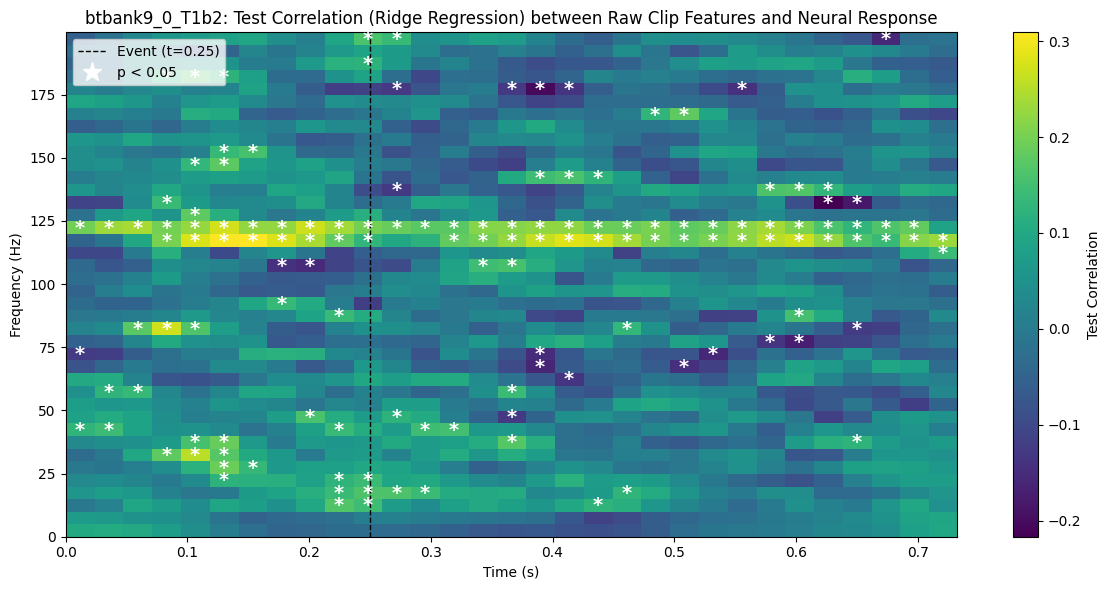

In [41]:
from sklearn.preprocessing import StandardScaler

n_timebins = y_spectrogram.shape[2]
n_freqs = y_spectrogram.shape[3]

correlation_matrix = np.zeros((n_freqs, n_timebins))
test_correlation_matrix = np.zeros((n_freqs, n_timebins))
test_pval_matrix = np.zeros((n_freqs, n_timebins))

n_samples = X.shape[0]
train_idx, test_idx = train_test_split(np.arange(n_samples), test_size=0.2, random_state=42)

# Fit scaler on training data only, apply to both train and test
scaler = StandardScaler()
X_train = X[train_idx]
X_test = X[test_idx]
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

for t in tqdm(range(n_timebins), desc="Timebin"):
    for f in range(n_freqs):
        # Get the neural response for all samples at this (t, f)
        y_vals = y_spectrogram[:, 0, t, f].cpu().numpy() if hasattr(y_spectrogram, 'cpu') else y_spectrogram[:, 0, t, f]
        y_train, y_test = y_vals[train_idx], y_vals[test_idx]
        reg = Ridge(alpha=0.1)
        reg.fit(X_train_scaled, y_train)
        y_pred_test = reg.predict(X_test_scaled)
        corr, pval = pearsonr(y_test, y_pred_test)
        test_correlation_matrix[f, t] = corr
        test_pval_matrix[f, t] = pval

plt.figure(figsize=(12, 6))
im = plt.imshow(
    test_correlation_matrix,
    aspect='auto',
    origin='lower',
    cmap='viridis',
    extent=[
        time_bins[0],
        time_bins[-1],
        freq_bins[0],
        freq_bins[-1]
    ]
)

star_y, star_x = np.where(test_pval_matrix < 0.05)

time_edges = np.linspace(
    time_bins[0].item() if hasattr(time_bins[0], 'item') else time_bins[0],
    time_bins[-1].item() if hasattr(time_bins[-1], 'item') else time_bins[-1],
    test_correlation_matrix.shape[1] + 1
)
freq_edges = np.linspace(
    freq_bins[0].item() if hasattr(freq_bins[0], 'item') else freq_bins[0],
    freq_bins[-1].item() if hasattr(freq_bins[-1], 'item') else freq_bins[-1],
    test_correlation_matrix.shape[0] + 1
)
time_centers = (time_edges[:-1] + time_edges[1:]) / 2
freq_centers = (freq_edges[:-1] + freq_edges[1:]) / 2 - 0.3

for y, x in zip(star_y, star_x):
    plt.text(
        time_centers[x], freq_centers[y], '*',
        color='white', fontsize=14, ha='center', va='center', fontweight='bold'
    )

event_time = 0.25
event_line = plt.axvline(event_time, color='black', linestyle='--', linewidth=1, label='Event (t=0.25)')
asterisk_handle = Line2D([0], [0], marker='*', color='w', linestyle='None', markersize=14, markerfacecolor='w', label='p < 0.05')

plt.colorbar(im, label='Test Correlation')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title(f'btbank{subject_id}_{trial_id}_{electrode_label}: Test Correlation (Ridge Regression) between Raw Clip Features and Neural Response')
plt.legend(handles=[event_line, asterisk_handle], loc='upper left', frameon=True)
plt.tight_layout()
plt.show()



=== Results for Ridge alpha=0.05 ===


Timebin (alpha=0.05):   0%|                                                                                                                           | 0/31 [00:00<?, ?it/s]

Timebin (alpha=0.05): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:38<00:00,  3.17s/it]


Test Correlation Matrix (shape (40, 31)):
[[ 0.10426434  0.10983671  0.10455874 ...  0.05676025  0.10827918
   0.13513539]
 [ 0.06591989  0.06968216  0.06203705 ...  0.05594744  0.11820972
   0.13163857]
 [-0.00632912 -0.01829357  0.02540278 ...  0.05233055  0.09893416
   0.05741414]
 ...
 [ 0.01182541 -0.03082148 -0.04125592 ...  0.00132943  0.00600004
   0.02342465]
 [ 0.00866954  0.01783469  0.01771213 ...  0.08700986  0.03895273
   0.01602284]
 [-0.04711226 -0.00980355  0.04654798 ... -0.15543296 -0.06132711
  -0.01617582]]
Test P-value Matrix (shape (40, 31)):
[[0.09404691 0.07765683 0.09311697 ... 0.36293589 0.08198608 0.02968548]
 [0.29055782 0.26383931 0.31996934 ... 0.3698597  0.0574502  0.03421759]
 [0.91925996 0.76951627 0.68407612 ... 0.401648   0.11219764 0.3574248 ]
 ...
 [0.84978089 0.62148783 0.50859874 ... 0.98301304 0.92344487 0.70750277]
 [0.88956806 0.7751412  0.7766455  ... 0.16266419 0.53256874 0.79746253]
 [0.45027784 0.87523396 0.45572799 ... 0.01225908 0.325549

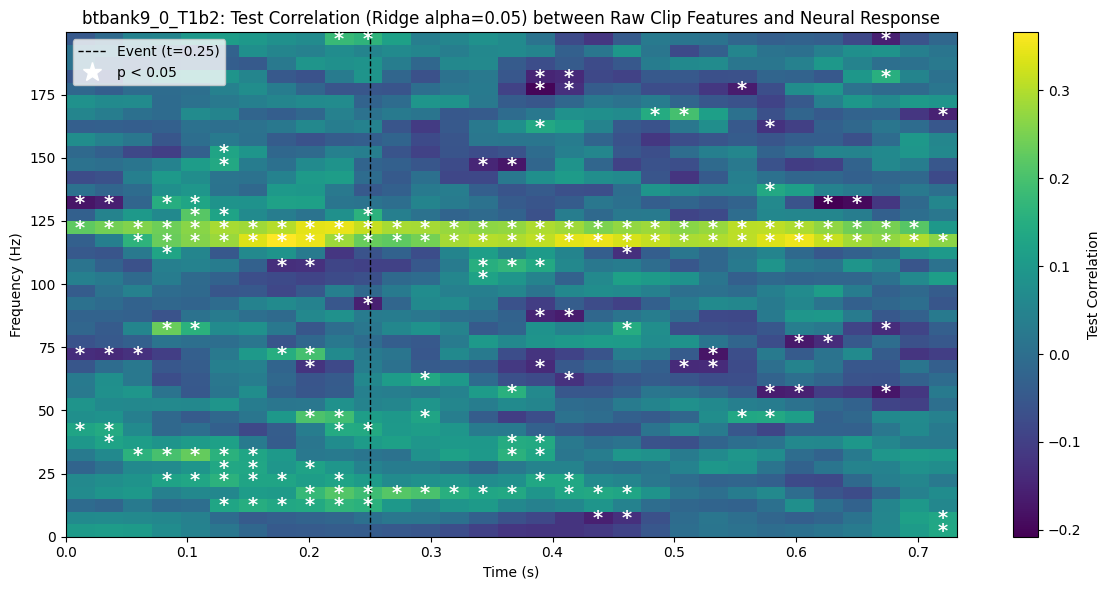


=== Results for Ridge alpha=0.1 ===


Timebin (alpha=0.1): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:41<00:00,  3.28s/it]


Test Correlation Matrix (shape (40, 31)):
[[ 0.10413789  0.11059951  0.10811801 ...  0.06727608  0.12027505
   0.1485415 ]
 [ 0.06356508  0.07028239  0.0666522  ...  0.0628278   0.1322178
   0.14796991]
 [-0.00990954 -0.02592924  0.01910443 ...  0.0441677   0.09685462
   0.06110149]
 ...
 [ 0.02381048 -0.02809449 -0.0590413  ...  0.02030892  0.03249278
   0.04795726]
 [ 0.0171891   0.02247216  0.01280182 ...  0.0973497   0.04908695
   0.02852149]
 [-0.03857927 -0.00776318  0.03807217 ... -0.15322298 -0.06744921
  -0.00620352]]
Test P-value Matrix (shape (40, 31)):
[[0.09444857 0.07560513 0.08244497 ... 0.28072528 0.05319866 0.01674441]
 [0.30817166 0.25973777 0.28522025 ... 0.3138279  0.03342857 0.01717387]
 [0.87389627 0.67789083 0.7596066  ... 0.47911974 0.11998285 0.32733571]
 ...
 [0.70291097 0.65268171 0.34393968 ... 0.74495875 0.60269433 0.44218535]
 [0.7830745  0.71888359 0.83754266 ... 0.11809231 0.4314968  0.64775541]
 [0.53650838 0.90105069 0.54188099 ... 0.01356591 0.2794864

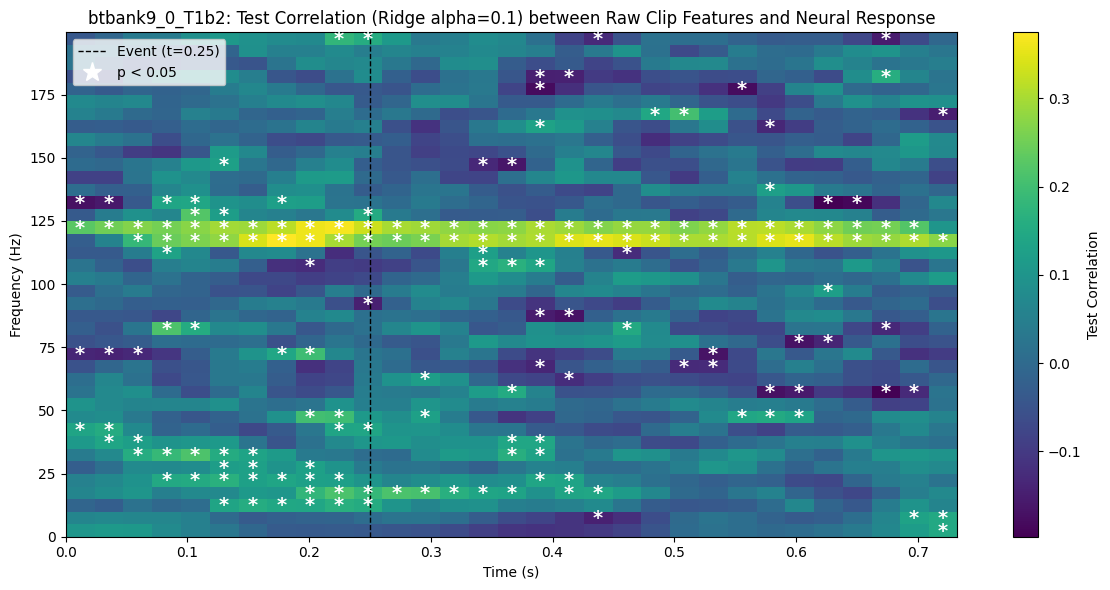


=== Results for Ridge alpha=0.2 ===


Timebin (alpha=0.2): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:40<00:00,  3.25s/it]


Test Correlation Matrix (shape (40, 31)):
[[ 0.10217959  0.10974099  0.111125   ...  0.07461567  0.1270181
   0.15558413]
 [ 0.05861157  0.06964738  0.07193988 ...  0.06883469  0.14253037
   0.15705734]
 [-0.01405911 -0.02933458  0.01990509 ...  0.04090643  0.0989157
   0.06574604]
 ...
 [ 0.03369433 -0.02455942 -0.06879964 ...  0.03855908  0.05596363
   0.0696414 ]
 [ 0.0256644   0.02600297  0.00903389 ...  0.10347017  0.05273234
   0.03740262]
 [-0.02691177 -0.00430411  0.02629473 ... -0.15127474 -0.07231052
   0.00270128]]
Test P-value Matrix (shape (40, 31)):
[[0.1008456  0.07791743 0.07421747 ... 0.23142892 0.04109647 0.01217388]
 [0.34746935 0.26407834 0.24864038 ... 0.26970561 0.02176521 0.01137054]
 [0.82184186 0.63841722 0.74985987 ... 0.51219949 0.11226496 0.29183468]
 ...
 [0.58934238 0.69402846 0.26995014 ... 0.53672183 0.36972099 0.26411943]
 [0.68099974 0.67702622 0.88495848 ... 0.09659243 0.39803828 0.54901529]
 [0.66640498 0.94504266 0.67360934 ... 0.01481785 0.2462046 

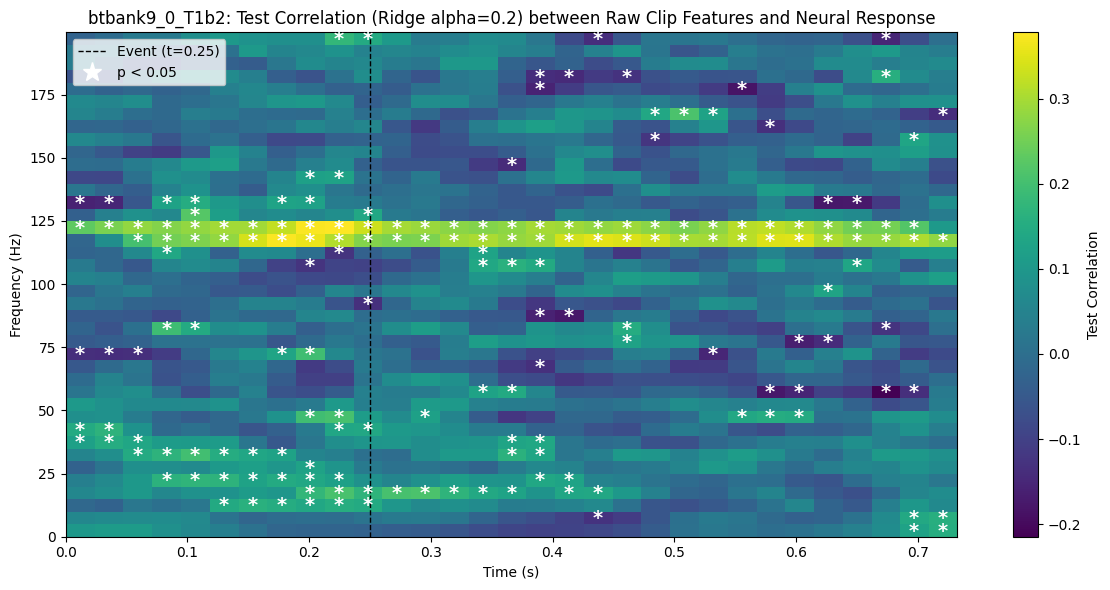


=== Results for Ridge alpha=0.4 ===


Timebin (alpha=0.4): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:38<00:00,  3.18s/it]


Test Correlation Matrix (shape (40, 31)):
[[ 9.79967956e-02  1.06404525e-01  1.11182799e-01 ...  7.76342743e-02
   1.26536271e-01  1.53416211e-01]
 [ 5.19789927e-02  6.75752120e-02  7.57035439e-02 ...  7.36287660e-02
   1.46972083e-01  1.55101189e-01]
 [-1.66671074e-02 -2.68326489e-02  2.80678088e-02 ...  4.41178968e-02
   1.06237073e-01  7.20074985e-02]
 ...
 [ 4.27509744e-02 -1.86116071e-02 -6.78928640e-02 ...  5.44038306e-02
   7.28795079e-02  8.51750512e-02]
 [ 3.28426995e-02  2.78193707e-02  7.27914540e-03 ...  1.07692063e-01
   5.14021269e-02  4.27944381e-02]
 [-1.25927131e-02  7.82653712e-05  1.30930741e-02 ... -1.49308563e-01
  -7.61062842e-02  8.14081499e-03]]
Test P-value Matrix (shape (40, 31)):
[[0.11565638 0.08745267 0.07406611 ... 0.21304272 0.04187661 0.01344695]
 [0.40482231 0.27858711 0.22467775 ... 0.23767635 0.01794664 0.0124479 ]
 [0.78950549 0.66732713 0.65299001 ... 0.479616   0.08795487 0.24819476]
 ...
 [0.49334572 0.76562494 0.27632867 ... 0.38323144 0.2424978 

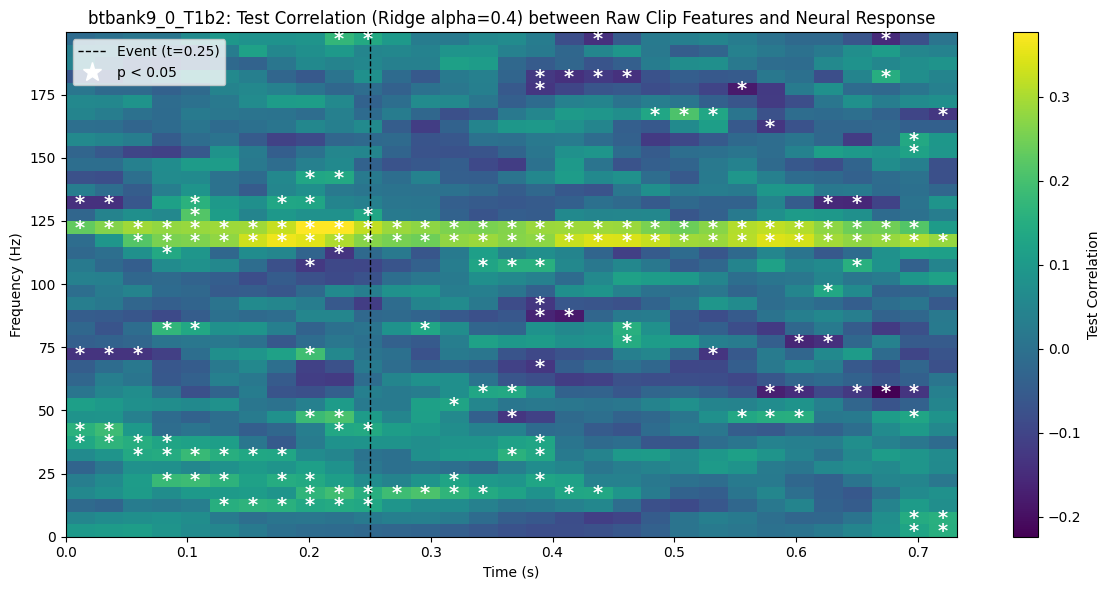


=== Results for Ridge alpha=0.8 ===


Timebin (alpha=0.8): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:39<00:00,  3.22s/it]


Test Correlation Matrix (shape (40, 31)):
[[ 0.09107676  0.09964461  0.1059282  ...  0.07599443  0.11882229
   0.1419645 ]
 [ 0.04472645  0.0635762   0.07520065 ...  0.07596721  0.14425099
   0.14241414]
 [-0.01726241 -0.01994817  0.04099785 ...  0.05211897  0.11730554
   0.07966662]
 ...
 [ 0.05109443 -0.01047408 -0.05830536 ...  0.06727065  0.08248318
   0.09333305]
 [ 0.03635076  0.02683272  0.00776896 ...  0.1108998   0.04764683
   0.04623006]
 [ 0.00347887  0.00491314  0.00038338 ... -0.14691882 -0.07811433
   0.00912632]]
Test P-value Matrix (shape (40, 31)):
[[0.14382578 0.10963061 0.08888724 ... 0.2228965  0.05616087 0.0222989 ]
 [0.47357082 0.30808686 0.22778104 ... 0.22306276 0.02020977 0.02187392]
 [0.7821725  0.74933652 0.51125628 ... 0.4035566  0.05939794 0.20126937]
 ...
 [0.41287509 0.8667771  0.34999834 ... 0.28076414 0.18574356 0.13411776]
 [0.5603155  0.66732627 0.90097747 ... 0.07480958 0.44514859 0.45881479]
 [0.95556771 0.93728113 0.995101   ... 0.01798873 0.210218

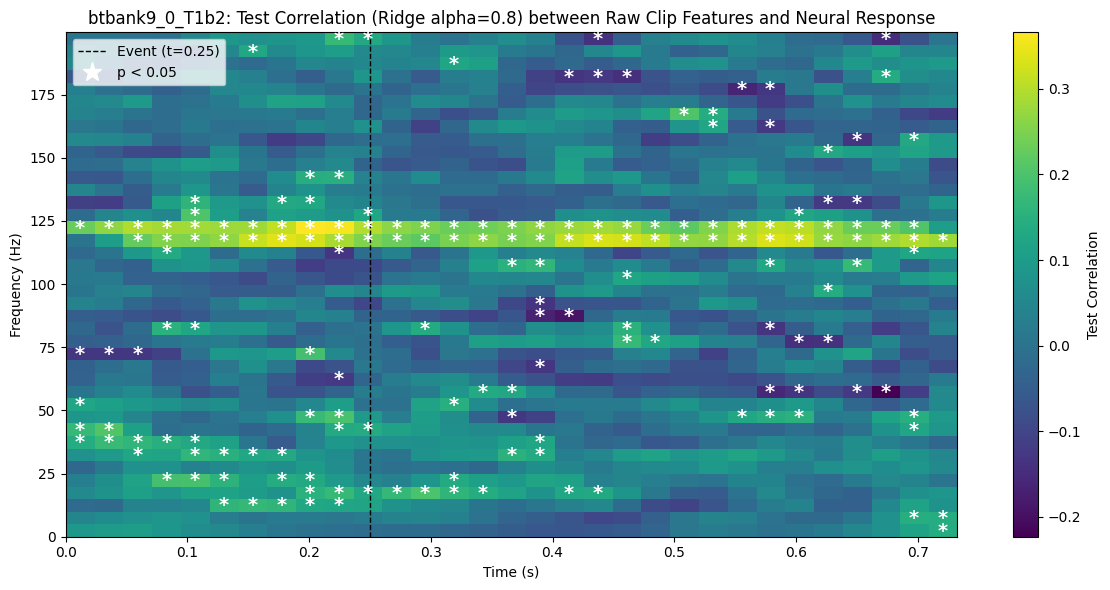


=== Results for Ridge alpha=1.0 ===


Timebin (alpha=1.0): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:37<00:00,  3.15s/it]


Test Correlation Matrix (shape (40, 31)):
[[ 0.08824003  0.09667364  0.10293709 ...  0.07452452  0.11504826
   0.13666967]
 [ 0.04244428  0.06183841  0.07387282 ...  0.07593305  0.14176645
   0.13662057]
 [-0.01705376 -0.0172592   0.04543497 ...  0.05507637  0.12098156
   0.08205784]
 ...
 [ 0.0532861  -0.00779197 -0.05416434 ...  0.07079632  0.08433634
   0.09460407]
 [ 0.03629075  0.02578578  0.00833659 ...  0.11139892  0.04605252
   0.04707552]
 [ 0.00888561  0.0066325  -0.00329387 ... -0.14595643 -0.07811364
   0.00853628]]
Test P-value Matrix (shape (40, 31)):
[[0.15678039 0.12067977 0.09833157 ... 0.23200102 0.06449914 0.02786509]
 [0.49645477 0.32152427 0.23612048 ... 0.22327153 0.02248834 0.02792183]
 [0.78474053 0.78221199 0.46658555 ... 0.37736963 0.05180564 0.18803   ]
 ...
 [0.39309529 0.90068569 0.38533214 ... 0.25626101 0.17601995 0.12887535]
 [0.56096353 0.67957417 0.89378369 ... 0.07350238 0.46054372 0.4506315 ]
 [0.88683398 0.91540391 0.95792824 ... 0.01876414 0.210222

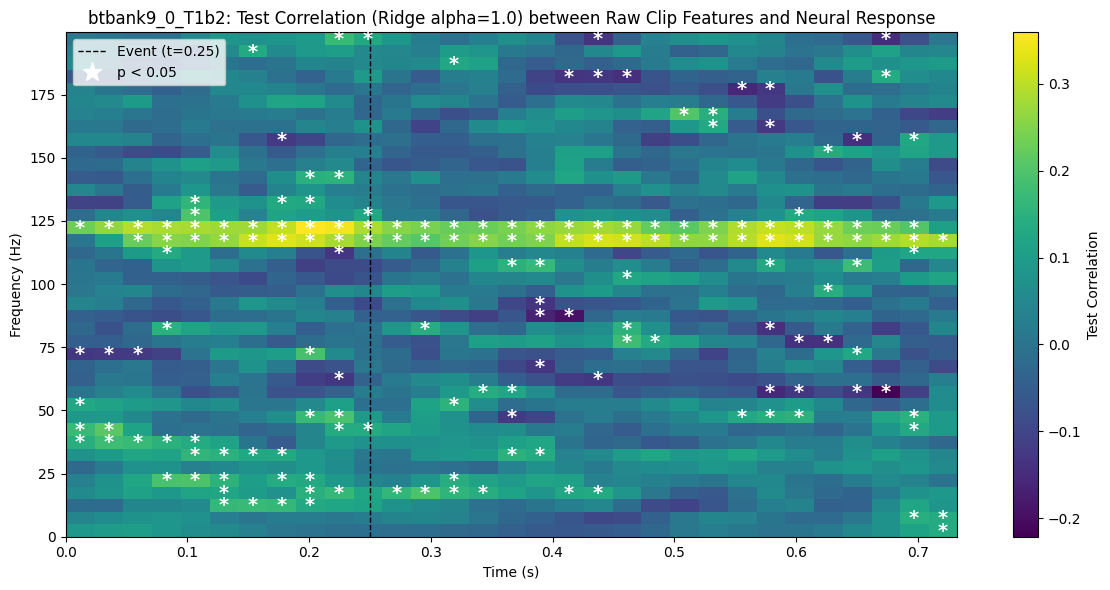

In [40]:
n_timebins = y_spectrogram.shape[2]
n_freqs = y_spectrogram.shape[3]

n_samples = X.shape[0]
train_idx, test_idx = train_test_split(np.arange(n_samples), test_size=0.2, random_state=42)

alpha_values = [0.05, 0.1, 0.2, 0.4, 0.8, 1.0]

for alpha in alpha_values:
    print(f"\n=== Results for Ridge alpha={alpha} ===")
    correlation_matrix = np.zeros((n_freqs, n_timebins))
    test_correlation_matrix = np.zeros((n_freqs, n_timebins))
    test_pval_matrix = np.zeros((n_freqs, n_timebins))

    for t in tqdm(range(n_timebins), desc=f"Timebin (alpha={alpha})"):
        for f in range(n_freqs):
            # Get the neural response for all samples at this (t, f)
            y_vals = y_spectrogram[:, 0, t, f].cpu().numpy() if hasattr(y_spectrogram, 'cpu') else y_spectrogram[:, 0, t, f]
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y_vals[train_idx], y_vals[test_idx]
            reg = Ridge(alpha=alpha)
            reg.fit(X_train, y_train)
            y_pred_test = reg.predict(X_test)
            corr, pval = pearsonr(y_test, y_pred_test)
            test_correlation_matrix[f, t] = corr
            test_pval_matrix[f, t] = pval

    print("Test Correlation Matrix (shape {}):".format(test_correlation_matrix.shape))
    print(test_correlation_matrix)
    print("Test P-value Matrix (shape {}):".format(test_pval_matrix.shape))
    print(test_pval_matrix)

    plt.figure(figsize=(12, 6))
    im = plt.imshow(
        test_correlation_matrix,
        aspect='auto',
        origin='lower',
        cmap='viridis',
        extent=[
            time_bins[0],
            time_bins[-1],
            freq_bins[0],
            freq_bins[-1]
        ]
    )

    star_y, star_x = np.where(test_pval_matrix < 0.05)

    time_edges = np.linspace(
        time_bins[0].item() if hasattr(time_bins[0], 'item') else time_bins[0],
        time_bins[-1].item() if hasattr(time_bins[-1], 'item') else time_bins[-1],
        test_correlation_matrix.shape[1] + 1
    )
    freq_edges = np.linspace(
        freq_bins[0].item() if hasattr(freq_bins[0], 'item') else freq_bins[0],
        freq_bins[-1].item() if hasattr(freq_bins[-1], 'item') else freq_bins[-1],
        test_correlation_matrix.shape[0] + 1
    )
    time_centers = (time_edges[:-1] + time_edges[1:]) / 2
    freq_centers = (freq_edges[:-1] + freq_edges[1:]) / 2 - 0.3

    for y, x in zip(star_y, star_x):
        plt.text(
            time_centers[x], freq_centers[y], '*',
            color='white', fontsize=14, ha='center', va='center', fontweight='bold'
        )

    event_time = 0.25
    event_line = plt.axvline(event_time, color='black', linestyle='--', linewidth=1, label='Event (t=0.25)')
    asterisk_handle = Line2D([0], [0], marker='*', color='w', linestyle='None', markersize=14, markerfacecolor='w', label='p < 0.05')

    plt.colorbar(im, label='Test Correlation')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'btbank{subject_id}_{trial_id}_{electrode_label}: Test Correlation (Ridge alpha={alpha}) between Raw Clip Features and Neural Response')
    plt.legend(handles=[event_line, asterisk_handle], loc='upper left', frameon=True)
    plt.tight_layout()
    plt.show()


Timebin (Fold 1/3):   0%|                                                                                                                             | 0/31 [00:00<?, ?it/s]

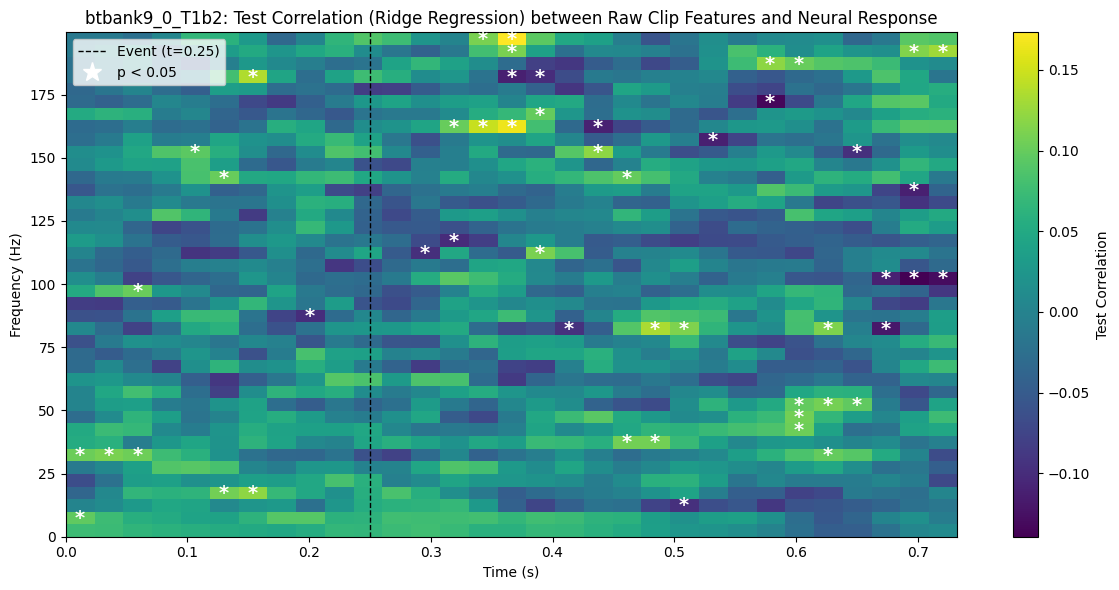

In [42]:
from sklearn.preprocessing import StandardScaler

n_timebins = y_spectrogram.shape[2]
n_freqs = y_spectrogram.shape[3]

n_samples = X.shape[0]
n_folds = 3

fold_size = n_samples // n_folds
fold_indices = [i * fold_size for i in range(n_folds)] + [n_samples]

# Store correlation and pval matrices for each fold
fold_correlation_matrices = []
fold_pval_matrices = []

for fold in range(n_folds):
    fold_corr_matrix = np.zeros((n_freqs, n_timebins))
    fold_pval_matrix = np.zeros((n_freqs, n_timebins))
    # Chronological split: train on all but the current fold, test on the current fold
    test_start = fold_indices[fold]
    test_end = fold_indices[fold + 1]
    test_idx = np.arange(test_start, test_end)
    train_idx = np.concatenate([
        np.arange(0, test_start),
        np.arange(test_end, n_samples)
    ]) if n_folds > 1 else np.arange(0, test_start)  # For n_folds=1, just use all before test

    X_train, X_test = X[train_idx], X[test_idx]

    # Normalize features using StandardScaler (fit on train, transform both train and test)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for t in tqdm(range(n_timebins), desc=f"Timebin (Fold {fold+1}/{n_folds})", leave=False):
        for f in range(n_freqs):
            y_vals = y_spectrogram[:, 0, t, f].cpu().numpy() if hasattr(y_spectrogram, 'cpu') else y_spectrogram[:, 0, t, f]
            y_train, y_test = y_vals[train_idx], y_vals[test_idx]
            if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
                # Not enough variance to compute correlation
                fold_corr_matrix[f, t] = np.nan
                fold_pval_matrix[f, t] = np.nan
                continue
            reg = Ridge(alpha=0.1)
            reg.fit(X_train_scaled, y_train)
            y_pred_test = reg.predict(X_test_scaled)
            corr, pval = pearsonr(y_test, y_pred_test)
            fold_corr_matrix[f, t] = corr
            fold_pval_matrix[f, t] = pval

    fold_correlation_matrices.append(fold_corr_matrix)
    fold_pval_matrices.append(fold_pval_matrix)

# Find the fold with the highest sum of absolute correlation values
fold_sums = [np.nansum(np.abs(mat)) for mat in fold_correlation_matrices]
best_fold_idx = np.argmax(fold_sums)

test_correlation_matrix = fold_correlation_matrices[best_fold_idx]
test_pval_matrix = fold_pval_matrices[best_fold_idx]

plt.figure(figsize=(12, 6))
im = plt.imshow(
    test_correlation_matrix,
    aspect='auto',
    origin='lower',
    cmap='viridis',
    extent=[
        time_bins[0],
        time_bins[-1],
        freq_bins[0],
        freq_bins[-1]
    ]
)

star_y, star_x = np.where(test_pval_matrix < 0.05)

time_edges = np.linspace(
    time_bins[0].item() if hasattr(time_bins[0], 'item') else time_bins[0],
    time_bins[-1].item() if hasattr(time_bins[-1], 'item') else time_bins[-1],
    test_correlation_matrix.shape[1] + 1
)
freq_edges = np.linspace(
    freq_bins[0].item() if hasattr(freq_bins[0], 'item') else freq_bins[0],
    freq_bins[-1].item() if hasattr(freq_bins[-1], 'item') else freq_bins[-1],
    test_correlation_matrix.shape[0] + 1
)
time_centers = (time_edges[:-1] + time_edges[1:]) / 2
freq_centers = (freq_edges[:-1] + freq_edges[1:]) / 2 - 0.3

for y, x in zip(star_y, star_x):
    plt.text(
        time_centers[x], freq_centers[y], '*',
        color='white', fontsize=14, ha='center', va='center', fontweight='bold'
    )

event_time = 0.25
event_line = plt.axvline(event_time, color='black', linestyle='--', linewidth=1, label='Event (t=0.25)')
asterisk_handle = Line2D([0], [0], marker='*', color='w', linestyle='None', markersize=14, markerfacecolor='w', label='p < 0.05')

plt.colorbar(im, label='Test Correlation')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title(f'btbank{subject_id}_{trial_id}_{electrode_label}: Test Correlation (Ridge Regression) between Raw Clip Features and Neural Response')
plt.legend(handles=[event_line, asterisk_handle], loc='upper left', frameon=True)
plt.tight_layout()
plt.show()


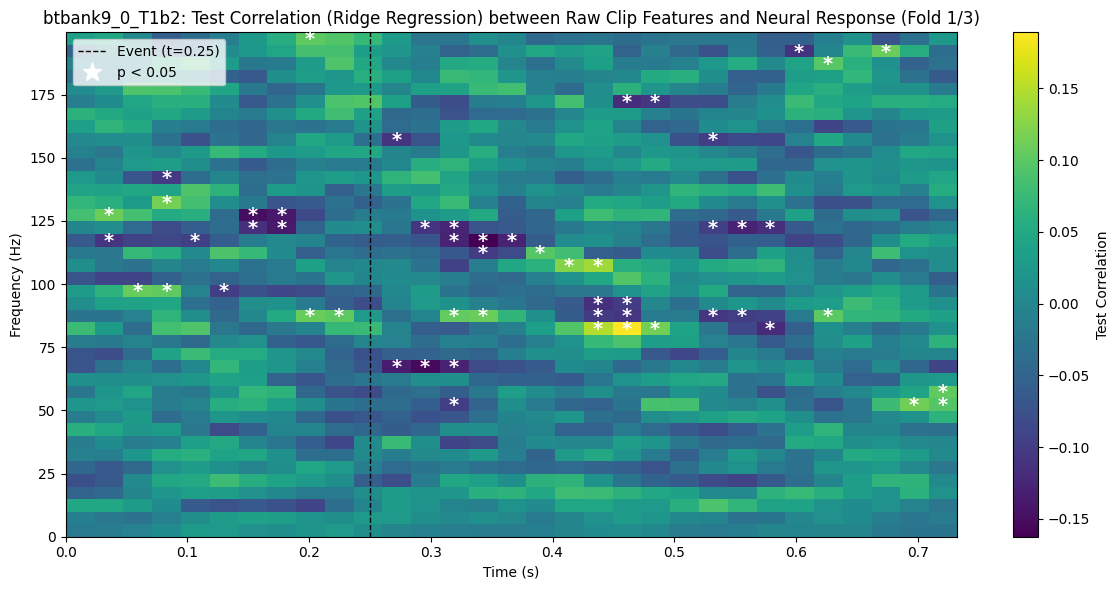

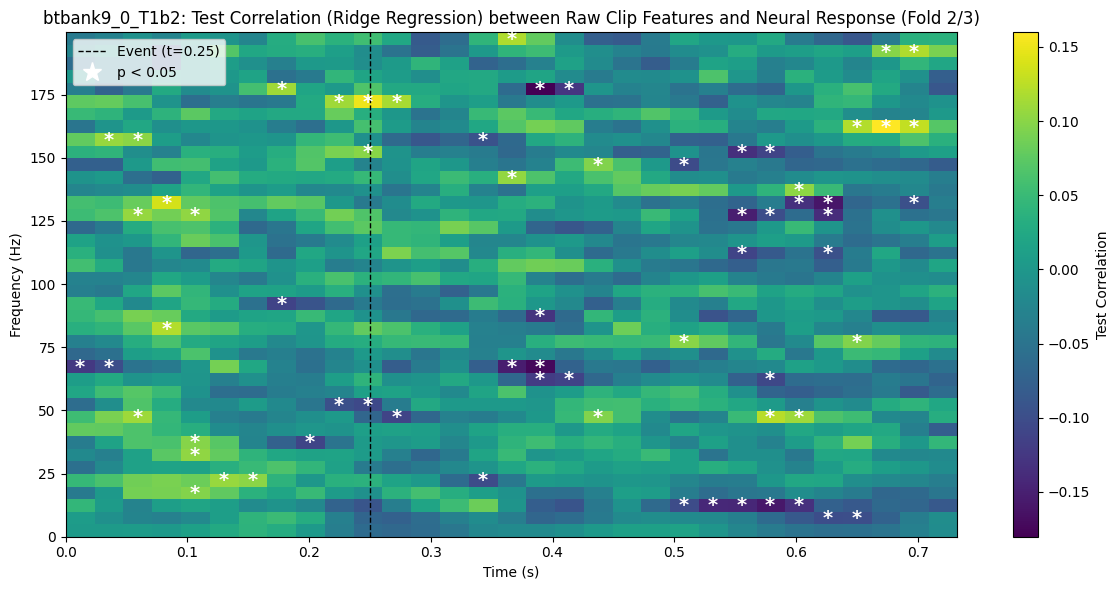

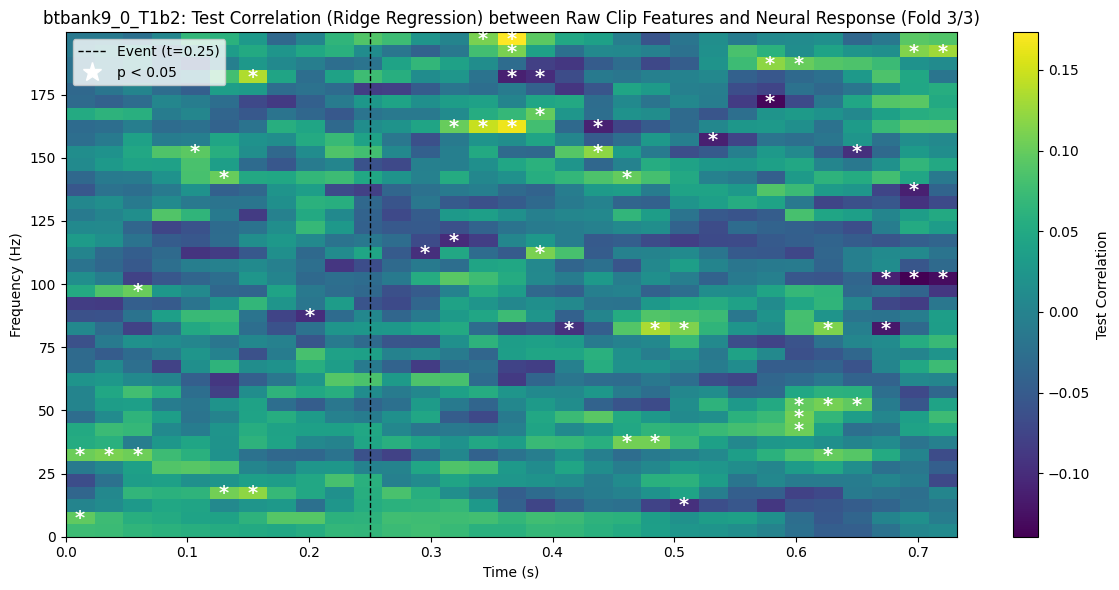

In [43]:
n_folds = len(fold_correlation_matrices)
for fold_idx in range(n_folds):
    plt.figure(figsize=(12, 6))
    im = plt.imshow(
        fold_correlation_matrices[fold_idx],
        aspect='auto',
        origin='lower',
        cmap='viridis',
        extent=[
            time_bins[0],
            time_bins[-1],
            freq_bins[0],
            freq_bins[-1]
        ]
    )

    star_y, star_x = np.where(fold_pval_matrices[fold_idx] < 0.05)

    time_edges = np.linspace(
        time_bins[0].item() if hasattr(time_bins[0], 'item') else time_bins[0],
        time_bins[-1].item() if hasattr(time_bins[-1], 'item') else time_bins[-1],
        fold_correlation_matrices[fold_idx].shape[1] + 1
    )
    freq_edges = np.linspace(
        freq_bins[0].item() if hasattr(freq_bins[0], 'item') else freq_bins[0],
        freq_bins[-1].item() if hasattr(freq_bins[-1], 'item') else freq_bins[-1],
        fold_correlation_matrices[fold_idx].shape[0] + 1
    )
    time_centers = (time_edges[:-1] + time_edges[1:]) / 2
    freq_centers = (freq_edges[:-1] + freq_edges[1:]) / 2 - 0.3

    for y, x in zip(star_y, star_x):
        plt.text(
            time_centers[x], freq_centers[y], '*',
            color='white', fontsize=14, ha='center', va='center', fontweight='bold'
        )

    event_time = 0.25
    event_line = plt.axvline(event_time, color='black', linestyle='--', linewidth=1, label='Event (t=0.25)')
    asterisk_handle = Line2D([0], [0], marker='*', color='w', linestyle='None', markersize=14, markerfacecolor='w', label='p < 0.05')

    plt.colorbar(im, label='Test Correlation')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'btbank{subject_id}_{trial_id}_{electrode_label}: Test Correlation (Ridge Regression) between Raw Clip Features and Neural Response (Fold {fold_idx+1}/{n_folds})')
    plt.legend(handles=[event_line, asterisk_handle], loc='upper left', frameon=True)
    plt.tight_layout()
    plt.show()
